# Introduction

## Anomaly detection

The goal of anomaly detection is to identify example sets which look like outliers with respect to the bulk of data. The key assumption is that there are at least two non-overlapping underlying statistical distributions with the examples we are interested in, the anomalies, coming from a rarely sampled distribution with respect to the bulk of the data.

In a real world analysis we would usually not know which data are from which distribution, at least until we start investigating the cause of statistical anomalies in the field through some kind of inspection process. In this workshop you have been provided with the class labels which effectively label the different distributions. That means in principle you can implement a supervised learning approach to get better performance, or at least bias the training data in favour of the distribution you would like to learn in an unsupervised or semi-supervised learning approach. 

## Dataset

The dataset consists of multivariate time series. Each time series is from a different turbofan engine. The data can be considered to be taken from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The sensor data are contaminated with noise. 

The data set is divided into training, validation, and testing subsets. Whereas the training and validation sets will be provided and used for data exploration and model development, we will use the test set for evaluation of the models that you will have built. 

The ground truth data provides the number of remaining working cycles for the engines. The engine is operating normally at the start of each time series, and develops a fault at some point in time during the series. In the training set, the fault grows in magnitude until system failure. In the validation and test sets, the time series ends some time prior to system failure. 

The data are provided in csv-formatted text file with 28 columns. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

- id: ID of the time series (one time series ~ one equipment)
- unit number
- time, in cycles
- operational setting 1
- operational setting 2
- operational setting 3
- sensor measurement 1
- sensor measurement 2
- ...
- sensor measurement 21
- label, 0 for normal and 1 for anomalies. 

<img src="images/data_overview.png" width=50% />

The original dataset itself does not have any directly applied class label. However, we know that an equipment develops a fault at some point which lasts until the end of the series, corresponding to a system failure. Based on that, We have assigned a label of anomaly (coded as 1) is assigned to samples that fall within a time window of 30 cycles prior to the system failure. All other samples are considered normal, coded as 0. 

## Challenge description

The objective of the workshop is to go through an end-to-end workflow of data exploration, building a model that detects anomalies with the highest possible true positive rate whereas keeping false alarm rate to a minimum, deploying the trained model in a cloud-based production environment, and evaluating its performance when running in production with unseen data. 


Failure in heavy-asset equipments is rare and catastrophic. In practice, when faced with the challenges of detecting failures for heavy-asset equipments, we likely do not have access to labeled failures or have access to such a limited  number of labels that it is impossible to use supervised approaches. 

Thus, for the competition in this workshop, despite that class label is provided in the training and validation sets, and that we will explore both supervised and unsupervised approaches, we will **only consider unsupervised or semi-supervised methods**, where the labels are not directly used while training a model. 

The model performance will be graded using the [f1-score](https://en.wikipedia.org/wiki/F1_score). 

# Exploratory data analysis

Let us load data: 


In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('../data/')

In [3]:
train_df = pd.read_csv(data_dir.joinpath('train.csv'))
validation_df = pd.read_csv(data_dir.joinpath('validation.csv'))
print(train_df.shape, validation_df.shape)

(20631, 28) (5245, 28)


In [4]:
features = ['setting{}'.format(i) for i in range(1, 4)]
features += ['s{}'.format(i) for i in range(1, 22)]

X_train, y_train = train_df[features], train_df['label']
X_validation, y_validation = validation_df[features],  validation_df['label']

The proportion between anomaly and normal training samples: 

In [5]:
class_ratio = y_train.value_counts()[1] / len(y_train)
print(class_ratio)

0.15025931850128446


Check for missing values

In [6]:
print("Training:", train_df.isnull().values.any())
print("Test:", validation_df.isnull().values.any())

Training: False
Test: False


Let us take a look at some basic statistics of each of the column in each set: 

In [7]:
train_df.groupby('id').describe().head()

RUL                                                      cycle         \
    count   mean        std  min    25%    50%     75%    max  count   mean   
id                                                                            
1   192.0   95.5  55.569776  0.0  47.75   95.5  143.25  191.0  192.0   96.5   
2   287.0  143.0  82.993976  0.0  71.50  143.0  214.50  286.0  287.0  144.0   
3   179.0   89.0  51.816986  0.0  44.50   89.0  133.50  178.0  179.0   90.0   
4   189.0   94.0  54.703748  0.0  47.00   94.0  141.00  188.0  189.0   95.0   
5   269.0  134.0  77.797815  0.0  67.00  134.0  201.00  268.0  269.0  135.0   

    ...   setting2         setting3                                          \
    ...        75%     max    count   mean  std    min    25%    50%    75%   
id  ...                                                                       
1   ...     0.0003  0.0005    192.0  100.0  0.0  100.0  100.0  100.0  100.0   
2   ...     0.0004  0.0006    287.0  100.0  0.0  100.0  100.0  100.0  100.0   
3   ...     0.0002  0.0005    179.0  100.0  0.0  100.0  100.0  100.0  100.0   
4   ...     0.0003  0.0006    189.0  100.0  0.0  100.0  100.0  100.0  100.0   
5   ...     0.0001  0.0005    269.0  100.0  0.0  100.0  100.0  100.0  100.0   

           
      max  
id         
1   100.0  
2   100.0  
3   100.0  
4   100.0  
5   100.0  

[5 rows x 216 columns]

In [8]:
validation_df.groupby('id').describe().head()

RUL                                                        cycle        \
    count   mean        std   min     25%    50%     75%    max  count  mean   
id                                                                             
4   106.0  134.5  30.743563  82.0  108.25  134.5  160.75  187.0  106.0  53.5   
6   105.0  145.0  30.454885  93.0  119.00  145.0  171.00  197.0  105.0  53.0   
8   166.0  177.5  48.064193  95.0  136.25  177.5  218.75  260.0  166.0  83.5   
11   83.0  138.0  24.103942  97.0  117.50  138.0  158.50  179.0   83.0  42.0   
15   76.0  120.5  22.083176  83.0  101.75  120.5  139.25  158.0   76.0  38.5   

    ...   setting2         setting3                                          \
    ...        75%     max    count   mean  std    min    25%    50%    75%   
id  ...                                                                       
4   ...     0.0003  0.0005    106.0  100.0  0.0  100.0  100.0  100.0  100.0   
6   ...     0.0003  0.0005    105.0  100.0  0.0  100.0  100.0  100.0  100.0   
8   ...     0.0002  0.0005    166.0  100.0  0.0  100.0  100.0  100.0  100.0   
11  ...     0.0003  0.0005     83.0  100.0  0.0  100.0  100.0  100.0  100.0   
15  ...     0.0002  0.0005     76.0  100.0  0.0  100.0  100.0  100.0  100.0   

           
      max  
id         
4   100.0  
6   100.0  
8   100.0  
11  100.0  
15  100.0  

[5 rows x 216 columns]

Some observations and remarks: 

- `s18` and `s19` are constant, both in the training and in the validation sets, suggesting that the operating condition did not change and/or these sensors was broken/inactive. We may disregard these variables from the analyses.
- Columns `s1`, `s5`, `s10` and `s16` are mostly constant and may be excluded from analyses too. 
- The statistics on the number of cycles are not relevant, as we should only look at the statistics for the maximum number of cycles for each engine. However, the mean and median number of cycles for the training set are larger than for the validation set, confirms the fact that in the training set, the engines run until system failure, wheras in the validation set, the time series ends prior to system failure.


Plot the sensors as a function of remaining useful life (RUL):

/Users/ntdoan/.local/share/virtualenvs/dsp-amld2019-9IuNj1PU/lib/python3.6/site-packages/seaborn/axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


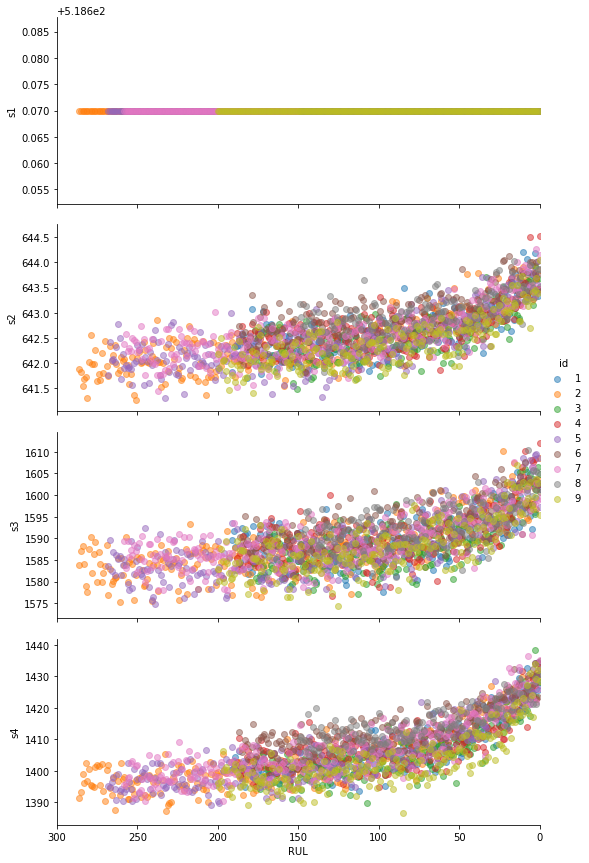

In [9]:
import seaborn as sns

g = sns.PairGrid(data=train_df.query('id < 10') ,
                 x_vars=['RUL'],
                 y_vars=['s1', 's2', 's3', 's4'],
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.scatter, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

**Exercise**: explore the relation of other sensors and RUL as well as the inter-correlation among the sensors.

# Unsupervised learning

In this section, we will build anomaly detection models using unsupervised approaches, i.e. the class labels are not used during this process. 

## Preprocessing

Normalize the features so that they are in the same range. 

In [10]:
from sklearn.preprocessing import RobustScaler
import numpy as np

scaler = RobustScaler()

# fit the scaler using the training data
scaler.fit(X_train)

# apply the scaler to both the training and validation sets
X_train_norm = scaler.transform(X_train)
X_validation_norm = scaler.transform(X_validation)

print(X_train_norm.shape, X_validation_norm.shape)

(20631, 24) (5245, 24)


## Model training

In [11]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

In [12]:
oneclass_SVM = OneClassSVM(nu=0.1, kernel="rbf", gamma='auto')
robust_covariance = EllipticEnvelope(contamination=0.05)

models_unsupervised = {
    'OneClassSVM': oneclass_SVM,
    'RobustCovariance': robust_covariance
}

Now, fit the models using the training data: 

In [13]:
for model_name, model in models_unsupervised.items():
    print("Fitting ", model_name)
    models_unsupervised[model_name] = model.fit(X_train_norm)
    

Fitting  OneClassSVM
Fitting  RobustCovariance


/Users/ntdoan/.local/share/virtualenvs/dsp-amld2019-9IuNj1PU/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


__Exercise__: build an anomaly detection model based on a different algorithm such as IsolationForest or Local Outlier Factor. 

# Model evaluation metrics

Let's apply our trained models to the validation set and calculate the model performance using accuracy and area under the ROC curve (AUC): 

In [14]:
from sklearn import metrics

def performance(yhat, y, score=None): 
    """calculate various model evaluation metrics
    Args: 
        yhat (binary): predicted label
        y (binay): true label
        score (float): anomaly score
    Returns: 
        dictionary containing different evaluation metrics
    """
    performance = {}
    performance['accuracy'] = metrics.accuracy_score(y, yhat)
    if score is not None: 
        FP, TP, _ = metrics.roc_curve(y, score)
        performance['FP_TP'] = (FP, TP)
        performance['AUC'] = metrics.auc(FP, TP)
    return performance

In [15]:
# utility function for plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confmat(y_true, y_pred):
    """
    Plot the confusion matrix and save to user_files dir
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,7))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='.0f')
    plt.title('Confusion matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')


Use the trained model to make detection on the validations set: 

In [16]:
results_unsupervised = {}
for model_name, model in models_unsupervised.items():
    # predict
    pred = model.predict(X_validation_norm)
    yhat = np.where(pred == -1, 1, 0)
    anomaly_score = - model.decision_function(X_validation_norm)
    perf = performance(yhat, y_validation, score=anomaly_score)
    results_unsupervised[model_name] = perf

    print('{model}: accuracy = {acc}, AUC = {auc}'.format(model=model_name, acc=perf['accuracy'], auc=perf['AUC']))

OneClassSVM: accuracy = 0.9229742612011439, AUC = 0.5979857717327377
RobustCovariance: accuracy = 0.9733079122974261, AUC = 0.6803700065976649


To gain more insights on the performance of the model on each class, let us take a look at the confusion matrix: 

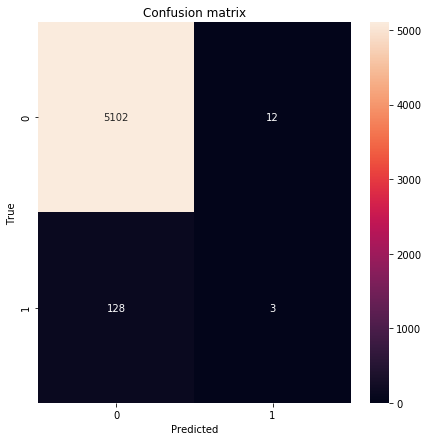

In [17]:
plot_confmat(y_validation, yhat)

Accuracy can be misleading particularly in the case of highy imbalanced data. In which cases, other metrics such as precision, recall and f1_score should be used. 

**Exercise**: add precision, recall, [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), and f1_score metrics to the `performance` function (ref. [commonly used evaluation metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)).



# Supervised learning

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor

Let us use the default values of the hyperparameters. Potentially, an improved model can be built by tuning the hyperparameters of an algorithm using cross-validation on the training data. 

In [19]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
knc = KNeighborsClassifier()
svc = SVC(gamma='auto', probability=True)

models_supervised = {
    'LogisticRegression': lr,
    'RandomForestClassifier':rfc,
    'KNeighborsClassifier': knc,
    'SVC': svc
}

Now, fit the models using the training data: 

In [20]:
for model_name, model in models_supervised.items():
    print("Fitting ", model_name)
    models_supervised[model_name] = model.fit(X_train_norm, y_train)
    

Fitting  LogisticRegression
Fitting  RandomForestClassifier


/Users/ntdoan/.local/share/virtualenvs/dsp-amld2019-9IuNj1PU/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ntdoan/.local/share/virtualenvs/dsp-amld2019-9IuNj1PU/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting  KNeighborsClassifier
Fitting  SVC


Apply the trained model on the validation data and calculate the performance. Note that we will make use of the `performance` function introduced in the "Unsupervised learning" section. 

In [21]:
results_supervised = {}
for model_name, model in models_supervised.items():
    # predict
    yhat = model.predict(X_validation_norm)
    anomaly_score = model.predict_proba(X_validation_norm)[:, 1]
    perf = performance(yhat, y_validation, score=anomaly_score)
    results_supervised[model_name] = perf

    print('{model}: accuracy = {acc}, AUC = {auc}'.format(model=model_name, acc=perf['accuracy'], auc=perf['AUC']))

LogisticRegression: accuracy = 0.9853193517635843, AUC = 0.9855120056602591
RandomForestClassifier: accuracy = 0.9837940896091516, AUC = 0.9220154522684324
KNeighborsClassifier: accuracy = 0.9843660629170639, AUC = 0.8566321458531736
SVC: accuracy = 0.984556720686368, AUC = 0.8723993706842764


# Deep learning-based approaches

In addition to the algorithms presented above, which are rather conventional machine learning algorithms, one may explore the use of deep learning-based algorithms as potential performant alternatives. 

Here we will experiment with the **autoencoder** as an unsupervised deep learning-based approach for anomaly detection. 

The autoencoder model aims to derive a data driven representation of the identity function. Given that by far the majority of the training data are of class normal we might expect this identity mapping to perform well for that class and less well for the class where we have far fewer training examples. It follows that if we calculate the performance of the mapping using, e.g., mean squared error, and determine a large quantile (e.g. 95%) of the performance we might start to identify the anomalies. 


First we construct the model. We will use a shallow autoencoder with no hyperparameter optimization (the setup of the hidden layer is fairly arbitrary and there may be significant room for improvement). As the model will have number of parameters comparable to a significant fraction of the training dataset we feel it's necessary to implement regularization to avoid overfitting; we use simple L1 but it might be interesting to see if dropout can improve performance.

In [22]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import keras.backend as K

K.clear_session()

# input layer
input_layer = Input(shape=(len(features), ))

# encoding layer with arbitrary hyperparameters and L1 regularization
encoder = Dense(
    20, activation="relu",
    activity_regularizer=regularizers.l1(10e-5)
)(input_layer)

# decoding layer
decoder = Dense(len(features), activation='relu')(encoder)

# book the model and summarize 
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                504       
Total params: 1,004
Trainable params: 1,004
Non-trainable params: 0
_________________________________________________________________


Next configure and train the model, we will save the model for later use, note this introduces a hidden dependency to h5py:

In [23]:
from keras.callbacks import ModelCheckpoint, TensorBoard

# require model be saved and logged
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

# compile the model for training
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

n_epochs = 100
batch_size = 64

# train
history = (
    autoencoder.fit(
        X_train_norm, X_train_norm,
        epochs=n_epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0, #set to 1 to monitor the fitting progress
        validation_data=[X_validation_norm, X_validation_norm],
        callbacks=[checkpointer, tensorboard]
    ).history
)

Now we have a trained model, let's plot the loss evolution as a function of training input:

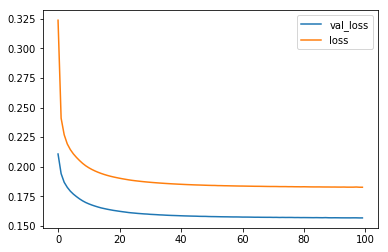

In [24]:
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss','loss'])

We can see that there is a considerable gap between the validation and training datasets, which indicates a potential for improving the model. Note however that the loss on the validation set is lower than that on the training set, which may appear to be counter-intuitive. 

**Exercise**: compare the class proportion (anomaly vs. normal) between the training and validation sets to find an explanation from a data-characteristics point of view to the difference in loss. 

Now we want to use the train data to determine the 95% threshold which assigns an anomaly and see how that impact the performance of anomaly detection on the validation data:

In [25]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error

K.clear_session()

trained_model = load_model('model.h5')
train_predicted = trained_model.predict(X_train_norm)
train_mse = mean_squared_error(train_predicted.T, X_train_norm.T, multioutput='raw_values')
thresh_train = np.percentile(train_mse, 95)
print(thresh_train)

0.478362830373819


In [26]:
from sklearn.metrics import precision_score, recall_score
# propagate the scaled validation data through prediction workflow
val_predicted = trained_model.predict(X_validation_norm)
val_mse = mean_squared_error(val_predicted.T, X_validation_norm.T, multioutput='raw_values')
yhat = [0 if imse < thresh_train else 1 for imse in val_mse]
performance(yhat, y_validation)

{'accuracy': 0.971210676835081}

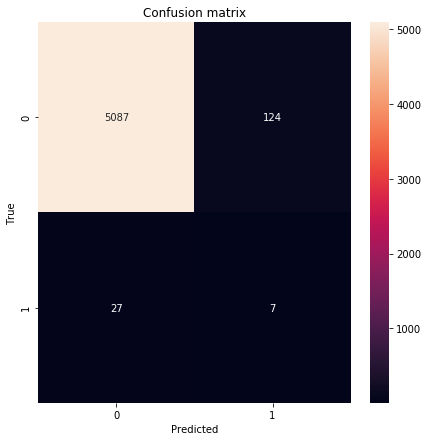

In [27]:
plot_confmat(yhat, y_validation)

**Exercise**: to avoid overfitting while tuning the model, split the original training set into two subsets: one used for training and the other one used for validation. The original validation would be used an an independent test set to evaluate the final model. Repeat the above analyses. Experiment with different quantile thresholds and network architectures and observe how the changes affect the performance. 



# Model persistence

Once a model is successfuly built with satisfying performance as quantified by an evaluation metric, it should be persisted for use in production to perform anomaly detection on unseen production data. 


A model can be persisted/saved as follows: 

In [28]:
from sklearn.externals import joblib

model_name = 'RandomForestClassifier'
model = models_supervised[model_name]

joblib.dump(model, '{}.model'.format(model_name))

['RandomForestClassifier.model']

Note that any preprocessing steps performed prior to model training, such as feature scaling, should also be persisted to be used on the production data. 

In [29]:
joblib.dump(scaler, 'scaler.model')

['scaler.model']

# Model comparison

In this section, we will compare the performance of all models that have been built so far: 

In [30]:
results = {**results_supervised, **results_unsupervised}

metrics_ = ['accuracy', 'AUC']

df = pd.DataFrame()
for model, result in results.items():
    df = df.append(
        pd.DataFrame(
            data={ key: result[key] for key in metrics_ },
            index=[model]
        )
    )
print(df)

                        accuracy       AUC
LogisticRegression      0.985319  0.985512
RandomForestClassifier  0.983794  0.922015
KNeighborsClassifier    0.984366  0.856632
SVC                     0.984557  0.872399
OneClassSVM             0.922974  0.597986
RobustCovariance        0.973308  0.680370


Plot ROC curve: 

In [31]:
model_names = ['OneClassSVM', 'LogisticRegression']
results_ = [results[model_name] for model_name in model_names]

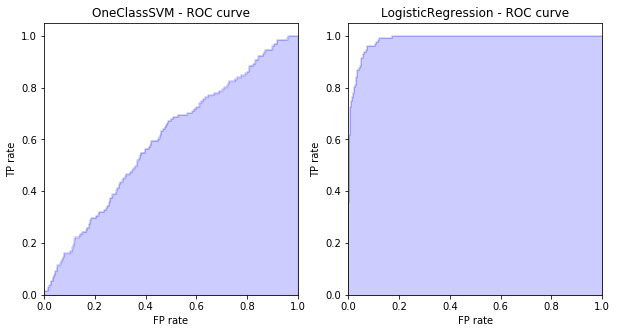

In [32]:
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

step_kwargs = (
    {'step': 'post'}
    if 'step' in signature(plt.fill_between).parameters
    else {}
)

_, ax = plt.subplots(1, len(model_names), figsize=(10,5))

for n, result in enumerate(results_):
    FP, TP = result['FP_TP']
    ax[n].step(FP, TP, color='b', alpha=0.2, where='post')
    ax[n].fill_between(FP, TP, alpha=0.2, color='b', **step_kwargs)
    ax[n].set_xlabel('FP rate')
    ax[n].set_ylabel('TP rate')
    ax[n].set_ylim([0.0, 1.05])
    ax[n].set_xlim([0.0, 1.0])
    ax[n].set_title('{} - ROC curve'.format(model_names[n]))

The above plot clearly shows a significant difference in performance between supervised and unsupervised learning. 

**Exercise**: plot the precision-recall curve in addition to the ROC curve for all models for comparison. 

# Challenge

Build your best model given the training and validation data and output your model, as well as any preprocessing steps needed, for the deployment step. 

Potential avenues for performance improvement: 
- Explore the use of other anomaly detection approaches (ref. [pyod](https://pyod.readthedocs.io/en/latest/), [scikit-learn](https://scikit-learn.org/stable/modules/outlier_detection.html)).
- Feature reduction using techniques such as Principal Component Analysis (PCA) or feature selection. 
- Resolve data imbalanced issue using data imputation.
- Model hyperparameter tuning using cross-validation. 


**NB: only unsupervised or semi-supervised approaches will be eligible for the competition**. 

# Conclusions

Through the analyses presented in this notebook, we have learned about: 
- End-to-end iterative model development workflow applied to anomaly detection using data of a physical equipment, consisting of: 
    - Exploratory data analysis,
    - Model training,
    - Model persistence for deployment. 
- A wide variety of anomaly detection approaches (supervised, unsupervised). 
- Different metrics that can be used for quantifying the performance of an anomaly detection model. 